# Feature 

In [124]:
import requests as rq
import json
import numpy as np
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import snownlp
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
from snownlp import SnowNLP


<font size=6>Read file</font>

In [125]:
train = pd.read_pickle('C:/Users/88690/Desktop/人工/NYCU-Intro-AI-Project/final-project/dataset/train.pkl')
feat_data = 'feat_v1'
save = True
'''
train = train.loc[train['n_comment'] != -1]
train = train.loc[train['abstract'] != '']
train = train.loc[train['abstract'] != ' ']
train = train.loc[train['abstract'] != '  ']
train = train.loc[train['headline'] != '']
train = train.drop(index = [31840, 8580, 23040, 23365, 27631, 42070, 36259])
train = train.reset_index().drop(columns=['index'])
'''
train

,web_url,print_section,print_page,news_desk,section_name,type_of_material,word_count,subsection_name,pub_year,pub_month,...,abstract_len,abstract_dup,headline,headline_len,headline_dup,headline_kicker,len_lead,keywords,authors,n_comment
0,https://www.nytimes.com/2020/12/31/opinion/202...,A,18,OpEd,Opinion,Op-Ed,882,NaN,2021,1,...,8,0,Things Will Get Better. Seriously.,5,0,None,54,"[Biden, Joseph R Jr, United States Economy, La...",[Paul Krugman],854
1,https://www.nytimes.com/2020/12/31/us/resolvin...,NaN,NaN,Express,U.S.,News,263,NaN,2021,1,...,51,0,Resolving to live a lot better than in 2020.,9,0,None,51,[],[Concepción de León],0
2,https://www.nytimes.com/2020/12/31/us/politics...,NaN,NaN,Washington,U.S.,News,695,Politics,2021,1,...,29,0,Justice Dept. Asks Judge to Toss Election Laws...,10,0,None,14,"[Justice Department, Presidential Election of ...","[Maggie Haberman, Katie Benner]",0
3,https://www.nytimes.com/2020/12/31/world/the-u...,NaN,NaN,Foreign,World,News,438,NaN,2021,1,...,39,0,The U.S. reaches 20 million cases.,6,0,None,39,[internal-essential],[Kate Taylor],0
4,https://www.nytimes.com/2020/12/31/us/mar-a-la...,NaN,NaN,National,U.S.,News,190,NaN,2021,1,...,17,0,The celebration at Mar-a-Lago doesn’t include ...,8,0,None,53,[],[Julia Echikson],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63223,https://www.nytimes.com/2022/12/31/opinion/bar...,NaN,NaN,OpEd,Opinion,Op-Ed,1169,NaN,2022,12,...,16,0,Katie Couric: What Barbara Walters Made Possib...,9,0,Guest Essay,22,"[Women and Girls, Television, Walters, Barbara...",[Katie Couric],0
63224,https://www.nytimes.com/2022/12/31/us/californ...,NaN,NaN,Express,U.S.,News,530,NaN,2022,12,...,24,0,Extreme Weather in California Causes Flooding ...,8,0,None,27,"[Floods, Landslides and Mudslides, Rain, Calif...",[April Rubin],0
63225,https://www.nytimes.com/2022/12/31/arts/televi...,NaN,NaN,Culture,Arts,News,1163,Television,2022,12,...,26,0,Dave Attell Bids a Heartfelt (and Hilarious) F...,10,0,On Comedy,13,"[Comedy and Humor, Television, Caroline's on B...","[Jason Zinoman, Photographs Westervelt]",0
63226,https://www.nytimes.com/2022/12/31/us/snowy-ow...,NaN,NaN,Express,U.S.,News,653,NaN,2022,12,...,15,0,‘Extremely Rare’ Snowy Owl Sighting Transfixes...,9,0,None,29,"[Owls, Audubon Society, National, ARCTIC REGIO...",[Michael Levenson],0


<font size=6>Set bound of popularity</font>

In [126]:
median = train['n_comment'].median()
print(median)
train['is_popular'] = train['n_comment'].apply(lambda x : 1 if x > median else 0)
pop_count = 0
for i in train['is_popular']:
    if i:
        pop_count += 1
print('popular:    ' , pop_count / len(train))
print('not popular:' , 1 - pop_count / len(train))
#train = train.drop(columns = ['n_comment'])

0.0
popular:     0.31810273929271843
not popular: 0.6818972607072815


In [127]:
print(train.columns)

Index(['web_url', 'print_section', 'print_page', 'news_desk', 'section_name',
       'type_of_material', 'word_count', 'subsection_name', 'pub_year',
       'pub_month', 'pub_day', 'pub_weekday', 'pub_time', 'abstract',
       'abstract_len', 'abstract_dup', 'headline', 'headline_len',
       'headline_dup', 'headline_kicker', 'len_lead', 'keywords', 'authors',
       'n_comment', 'is_popular'],
      dtype='object')


<font size=6>Hour</font>


pub_time
0     0.294524
1     0.249766
2     0.377818
3     0.278947
4     0.234722
5     0.263348
6     0.463722
7     0.650129
8     0.550375
9     0.527584
10    0.485840
11    0.241646
12    0.193739
13    0.285611
14    0.294880
15    0.267479
16    0.265204
17    0.230283
18    0.237417
19    0.230388
20    0.185197
21    0.151812
22    0.167807
23    0.278748
Name: is_popular, dtype: float64
0.27033417671481375


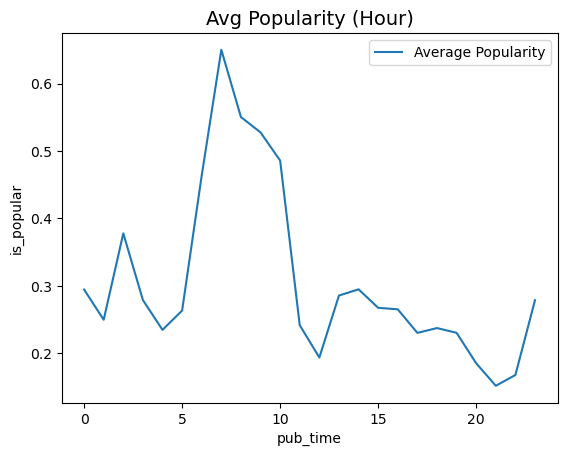

In [128]:
print(train.groupby('pub_time').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_time').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Hour)', fontsize=14)
#plt.axvline(x = 3, linestyle= '--')

train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (6 <= x and x <= 10) else 0)
print(train.corr()['is_popular']['is_noon'])

<font size=6>Weekday</font>

In [129]:
print(train.groupby('pub_weekday').mean()['is_popular'])

pub_weekday
0    0.356474
1    0.345132
2    0.370576
3    0.330815
4    0.265962
5    0.225390
6    0.262252
Name: is_popular, dtype: float64


<font size=6>Day of week</font>

0.06700946977030844


Text(0.5, 1.0, 'Avg Popularity (Day of Week)')

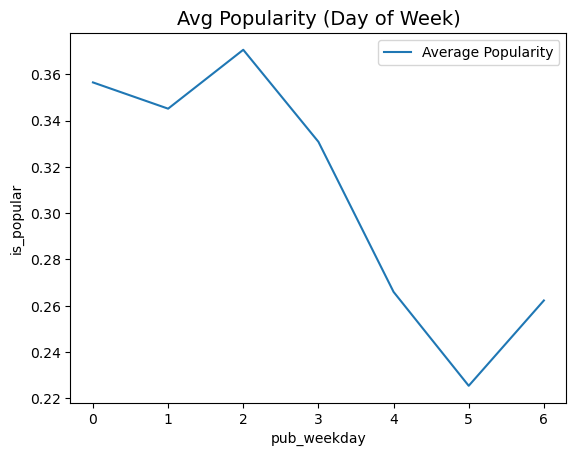

In [130]:
train['is_weekday'] = train['pub_weekday'].apply(lambda x : 1 if (x < 5) else 0)
print(train.corr()['is_popular']['is_weekday'])
sns.lineplot(data = train.groupby('pub_weekday').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Day of Week)', fontsize=14)

<font size=6>Day of month</font>

pub_day
1     0.312022
2     0.294679
3     0.316714
4     0.324418
5     0.301235
6     0.325922
7     0.324826
8     0.324957
9     0.311505
10    0.326014
11    0.316901
12    0.309812
13    0.330963
14    0.304188
15    0.310757
16    0.326149
17    0.327909
18    0.311753
19    0.316336
20    0.319527
21    0.322402
22    0.329645
23    0.297297
24    0.309761
25    0.313333
26    0.316004
27    0.347408
28    0.333015
29    0.321606
30    0.312968
31    0.332613
Name: is_popular, dtype: float64


Text(0.5, 1.0, 'Avg Popularity (day)')

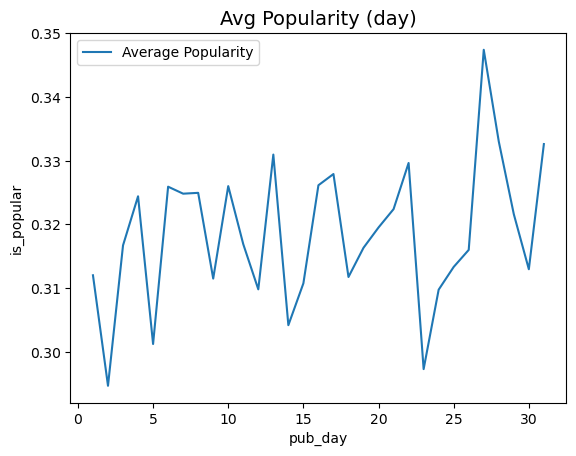

In [131]:
print(train.groupby('pub_day').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_day').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (day)', fontsize=14)

<font size=6>Month</font>

pub_month
1     0.309228
2     0.295859
3     0.325505
4     0.328460
5     0.322260
6     0.308170
7     0.304878
8     0.318579
9     0.319607
10    0.328728
11    0.318478
12    0.337925
Name: is_popular, dtype: float64
0.006727687767738176


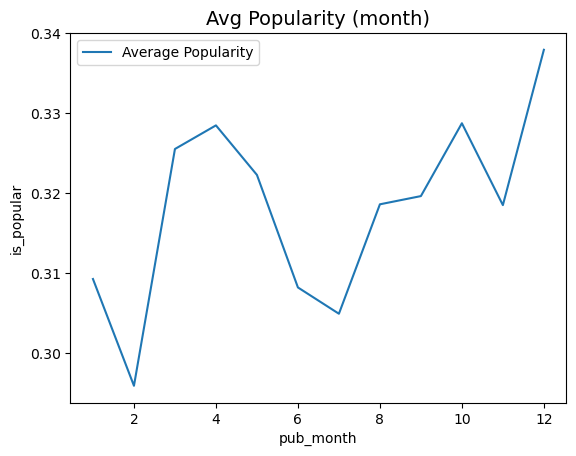

In [132]:
print(train.groupby('pub_month').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_month').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (month)', fontsize=14)
train['is_lowmonth'] = train['pub_time'].apply(lambda x : 0 if (x <= 2) else 1)
print(train.corr()['is_popular']['is_lowmonth'])
#print(train.corr()['is_popular']['is_noon'])

<font size=6>News desk</font>

In [133]:
col = 'news_desk'
dst = 'newsdesk'
train[f'group_by_{col}'] = train['is_popular'].groupby(train[f'{col}']).transform('mean')
train = train.reset_index(drop=True)
table = dict()
for i in range(len(train)):
    table[train[f'{col}'][i]] = train[f'group_by_{col}'][i]

with open(f'./table/{dst}.pkl', 'wb') as handle:
    pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(table)

#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular'][f'group_by_{col}'])
train[f'feature_{col}'] = train[f'group_by_{col}'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular'][f'feature_{col}'])

{'OpEd': 0.5176555368724478, 'Express': 0.11003236245954692, 'Washington': 0.26525067918004447, 'Foreign': 0.20088483340246094, 'National': 0.23458646616541354, 'Summary': 0.17694805194805194, 'Corrections': 0.0, 'NYTNow': 0.011123470522803115, 'Styles': 0.25582479030754895, 'Sports': 0.2286783042394015, 'Business': 0.23627287853577372, 'Metropolitan': 0.6792929292929293, 'Well': 0.7890855457227138, 'Arts&Leisure': 0.46497764530551416, 'Upshot': 0.9567901234567902, 'Climate': 0.4253968253968254, 'Science': 0.41367861885790175, 'RealEstate': 0.8398849472674976, 'Society': 0.05405405405405406, 'Briefing': 0.007518796992481203, 'Books': 0.3010033444816054, 'Dining': 0.41406768414067685, 'Obits': 0.15609137055837563, 'Metro': 0.40891880521665963, 'Culture': 0.3436911487758945, 'AtHome': 0.024844720496894408, 'Politics': 0.23985239852398524, 'SundayBusiness': 0.3127659574468085, 'Opinion': 0.33636363636363636, 'Games': 0.9681159420289855, 'Letters': 0.0, 'Editorial': 0.5785953177257525, 'Th

<font size=6>Section</font>

In [134]:
col = 'section_name'
dst = 'section'
train[f'group_by_{col}'] = train['is_popular'].groupby(train[f'{col}']).transform('mean')
table = dict()
for i in range(len(train)):
    table[train[f'{col}'][i]] = train[f'group_by_{col}'][i]

with open(f'./table/{dst}.pkl', 'wb') as handle:
    pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(table)

#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular'][f'group_by_{col}'])
train[f'feature_{col}'] = train[f'group_by_{col}'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular'][f'feature_{col}'])

{'Opinion': 0.46581280788177337, 'U.S.': 0.21664034741413343, 'World': 0.19875933662488923, 'Today’s Paper': 0.002232142857142857, 'Corrections': 0.0, 'Briefing': 0.01037117903930131, 'Style': 0.2549295774647887, 'Sports': 0.22435897435897437, 'Business Day': 0.22910835665733706, 'New York': 0.4203378602186154, 'Well': 0.7889784946236559, 'Movies': 0.1352973267866885, 'The Upshot': 0.6746575342465754, 'Climate': 0.42242703533026116, 'Science': 0.37409200968523004, 'Real Estate': 0.7730870712401056, 'Your Money': 0.08552631578947369, 'Arts': 0.30927606818684966, 'Books': 0.2216, 'Food': 0.4095299420476497, 'Health': 0.4102870813397129, 'At Home': 0.0, 'Admin': 0.038461538461538464, 'Obituaries': 0.15591397849462366, 'Crosswords & Games': 0.9636363636363636, 'Times Insider': 0.8212765957446808, 'Theater': 0.48014440433212996, 'Technology': 0.3271276595744681, 'The Learning Network': 0.827426810477658, 'Podcasts': 0.5700280112044818, 'Magazine': 0.7205346294046172, 'Fashion & Style': 0.25

<font size=6>Subsection</font>

In [135]:
col = 'subsection_name'
dst = 'subsection'
train[f'group_by_{col}'] = train['is_popular'].groupby(train[f'{col}']).transform('mean')
table = dict()
for i in range(len(train)):
    table[train[f'{col}'][i]] = train[f'group_by_{col}'][i]

with open(f'./table/{dst}.pkl', 'wb') as handle:
    pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(table)

#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular'][f'group_by_{col}'])
train[f'feature_{col}'] = train[f'group_by_{col}'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular'][f'feature_{col}'])

{nan: nan, nan: nan, 'Politics': 0.2669017005391954, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, 'College Football': 0.2087912087912088, nan: nan, nan: nan, nan: nan, 'Family': 0.9016393442622951, 'Olympics': 0.0903954802259887, nan: nan, nan: nan, nan: nan, nan: nan, 'Hockey': 0.25, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, nan: nan, 'Asia Pacific': 0.28211749515816653, nan: nan, nan: nan, nan: nan, 'Soccer': 0.20518867924528303, 'Television': 0.452572347266881, 'Music': 0.24116847826086957, nan: nan, nan: nan, nan: nan, nan: nan, 'Book Review': 0.1436651583710407, 'Self-Care': 0.375, nan: nan, nan: nan, 'Americas': 0.2893081761006289, nan: nan, 'Europe': 0.20643827525103367, 'Art & Design': 0.31889290012033694, nan: nan, nan: nan, 'Canada': 0.1218274111675127, nan: nan, nan: nan, nan: nan, nan: nan, 'Middle East': 0.20977917981072555, nan: nan, nan: nan, 'Economy': 0.4020797227036395, nan: nan, nan: nan, nan: nan, nan: n

<font size=6>Material</font>

In [136]:
col = 'type_of_material'
dst = 'material'
train[f'group_by_{col}'] = train['is_popular'].groupby(train[f'{col}']).transform('mean')
table = dict()
for i in range(len(train)):
    table[train[f'{col}'][i]] = train[f'group_by_{col}'][i]

with open(f'./table/{dst}.pkl', 'wb') as handle:
    pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(table)

#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular'][f'group_by_{col}'])
train[f'feature_{col}'] = train[f'group_by_{col}'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular'][f'feature_{col}'])

{'Op-Ed': 0.5198487712665406, 'News': 0.3318475317642158, 'Quote': 0.0, 'Correction': 0.0, 'briefing': 0.16906130268199235, 'Interactive Feature': 0.20671140939597316, 'Obituary (Obit)': 0.16155291170945524, 'Letter': 0.0022701475595913734, 'Editorial': 0.5085714285714286, 'Review': 0.25048923679060664, '': 0.0, 'List': 0.013888888888888888, 'News Analysis': 0.5662650602409639, "Editors' Note": 0.0, 'An Appraisal': 0.0, 'Biography': 0.0}
0.18974955591669387
0.1836612626362872


<font size=6>Keyword</font>

<font size=5>Politics<font size=4>( party, congress, president )</font></font>


In [137]:
train['is_party'] = train['keywords'].apply(lambda x: 1 if ('Democratic Party' in x or 'Republican Party' in x ) else 0)
train['is_congress'] = train['keywords'].apply(lambda x: 1 if ('House of Representatives' in x or 'Senate' in x) else 0)
train['is_president'] = train['keywords'].apply(lambda x: 1 if ('Trump, Donald J' in x or 'Biden, Joseph R Jr' in x)else 0)
print(train.corr()['is_popular']['is_party'])
print(train.corr()['is_popular']['is_congress'])
print(train.corr()['is_popular']['is_president'])

0.0747245023783232
0.03126890311545747
0.05524818799901686


<font size=5>Event <font size=4>( Ukrainian_Russian_war, covid, Storming of the US Capitol )</font></font>


In [138]:
train['is_ukrainian_russian_war'] = train['keywords'].apply(lambda x: 1 if ('War and Armed Conflicts' in x or 'Ukraine' in x ) else 0)
train['is_covid'] = train['keywords'].apply(lambda x: 1 if 'Coronavirus (2019-nCoV)' in x else 0)
train['is_storm'] = train['keywords'].apply(lambda x: 1 if 'Storming of the US Capitol (Jan, 2021)' in x else 0)
print('ukrainian_russian_war     ', train.corr()['is_popular']['is_ukrainian_russian_war'])
print('Coronavirus               ', train.corr()['is_popular']['is_covid'])
print('Storming of the US Capitol', train.corr()['is_popular']['is_storm'])

ukrainian_russian_war      -0.01711591378491107
Coronavirus                -0.008319868561523065
Storming of the US Capitol 0.018062328389029523


<font size=5>News game<font size=4>(spelling bee, crossword puzzle)</font></font>

In [139]:
train['is_spell'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)' in x else 0)
train['is_crossword'] = train['keywords'].apply(lambda x: 1 if 'Crossword Puzzles' in x else 0)
train['is_game'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)'  in x or 'Crossword Puzzles' in x else 0)
print(train.corr()['is_popular']['is_spell'])
print(train.corr()['is_popular']['is_crossword'])
print(train.corr()['is_popular']['is_game'])

0.1159666087988717
0.12746626759797472
0.1730848863570038


<font size=6>Headline length</font>

-0.07859700209734115


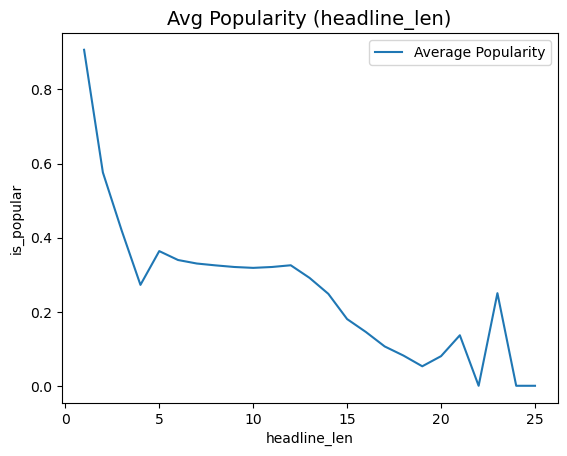

In [140]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('headline_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (headline_len)', fontsize=14)
print(train.corr()['is_popular']['headline_len'])

<font size=6>Abstract length</font>

-0.03828925134587252


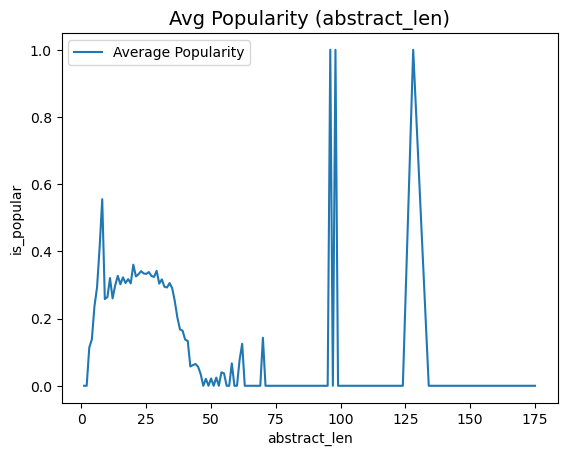

In [141]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_len)', fontsize=14)
print(train.corr()['is_popular']['abstract_len'])

<font size=6>Word count</font>

0.20436772661553007


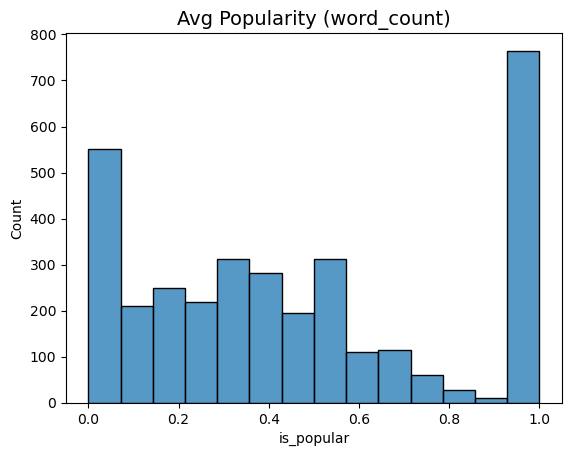

In [142]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.histplot(data = train.groupby('word_count').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (word_count)', fontsize=14)
print(train.corr()['is_popular']['word_count'])

0.04410919131401947


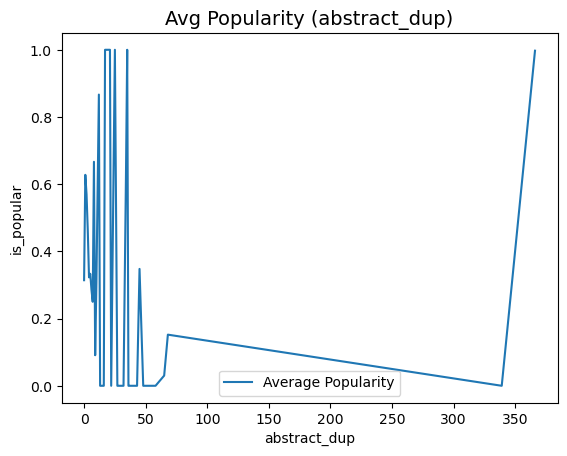

In [143]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_dup').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_dup)', fontsize=14)
print(train.corr()['is_popular']['abstract_dup'])

<font size=6>Lead paragraph length</font>

0.04667152647048925


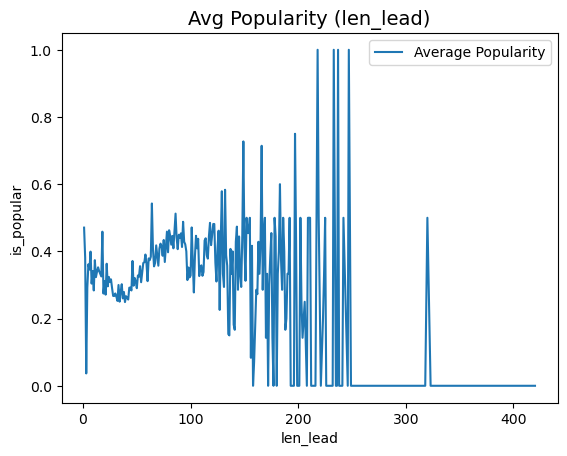

In [144]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('len_lead').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (len_lead)', fontsize=14)
print(train.corr()['is_popular']['len_lead'])

<font size = 6>Sentiment analyze</font>

<font size = 5>punctuation removal</font>

In [145]:
punct_list = list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
def remove_punctuation(headline):
    for punc in punct_list:
        if punc in headline:
            headline = headline.replace(punc, ' ')
    return headline
train['clean_headline'] = train['headline'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [146]:

text = "i am happy today."
blob = TextBlob(text)
# get the sentiment of the text
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.8, subjectivity=1.0)


In [147]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_tb_polar'] = train['clean_headline'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_tb_polar_abs'] = train['sentiment_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_tb_subj'] = train['clean_headline'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_tb_pos'] = train['sentiment_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_tb_polar'])
print(train.corr()['is_popular']['sentiment_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_tb_subj'])
print(train.corr()['is_popular']['sentiment_tb_pos'])

0.0008044140424590058
0.023688289701197757
0.02534893974363013
0.0037961736890695977


<font size = 5>vader</font>

In [148]:
headline = 'today is a sunny day!'
analyzer = SentimentIntensityAnalyzer ()
sentiment_dict = analyzer.polarity_scores(headline)
print(sentiment_dict)

{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'compound': 0.4753}


In [149]:
train['sentiment_vader_neg'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_vader_neu'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_vader_pos'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_vader_compound'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_vader_neg'])
print(train.corr()['is_popular']['sentiment_vader_neu'])
print(train.corr()['is_popular']['sentiment_vader_pos'])
print(train.corr()['is_popular']['sentiment_vader_compound'])
print(train.corr()['is_popular']['sentiment_vader_compound_abs'])

-0.009686725775924844
-0.00870624564258787
0.022072307371213892
0.022333821922085516
-0.012276245493700098


<font size = 5>snownlp</font>

In [150]:
headline = 'i am happy'
sentence = 'hello","why is it not working?!'
s = SnowNLP(headline)
print(s.sentiments)

0.1837233963534416


In [151]:
train['sentiment_snow'] = train['clean_headline'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_snow_abs'] = train['sentiment_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_snow_pos'] = train['sentiment_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_snow'])
print(train.corr()['is_popular']['sentiment_snow_abs'])
print(train.corr()['is_popular']['sentiment_snow_pos'])

0.007474427612226912
-0.016238225917170817
-0.022035047367087533


<font size = 6>abstract</font>

In [152]:

train['clean_abstract'] = train['abstract'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [153]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_abstract_tb_polar'] = train['clean_abstract'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_abstract_tb_polar_abs'] = train['sentiment_abstract_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_abstract_tb_subj'] = train['clean_abstract'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_abstract_tb_pos'] = train['sentiment_abstract_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_tb_polar'])
print(train.corr()['is_popular']['sentiment_abstract_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_abstract_tb_subj'])
print(train.corr()['is_popular']['sentiment_abstract_tb_pos'])

0.023174836604924327
0.04925605820273595
0.053083589845526934
0.03505408932165935


<font size = 5>vader</font>

In [154]:
train['sentiment_abstract_vader_neg'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_abstract_vader_neu'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_abstract_vader_pos'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_abstract_vader_compound'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_abstract_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_abstract_vader_neg'])
print(train.corr()['is_popular']['sentiment_abstract_vader_neu'])
print(train.corr()['is_popular']['sentiment_abstract_vader_pos'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound_abs'])

0.005645109367282879
-0.06655813945885308
0.08116259398621124
0.041882394630012476
-0.012276245493700098


<font size = 5>snownlp</font>

In [155]:
train['sentiment_abstract_snow'] = train['clean_abstract'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_abstract_snow_abs'] = train['sentiment_abstract_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_abstract_snow_pos'] = train['sentiment_abstract_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_snow'])
print(train.corr()['is_popular']['sentiment_abstract_snow_abs'])
print(train.corr()['is_popular']['sentiment_abstract_snow_pos'])

0.04657711998969139
-0.03422619912916177
0.028726254036756244


In [156]:
train = train.drop(columns=['web_url', 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'pub_weekday'])

In [157]:
fea_list = train.corr()['is_popular']
fea_list = fea_list.sort_values(key = lambda x : abs(x), ascending=False)
print(fea_list)

is_popular                               1.000000
n_comment                                0.454114
group_by_news_desk                       0.446084
feature_news_desk                        0.442014
group_by_section_name                    0.422631
feature_section_name                     0.420482
group_by_subsection_name                 0.374180
feature_subsection_name                  0.370269
is_noon                                  0.270334
word_count                               0.204368
group_by_type_of_material                0.189750
feature_type_of_material                 0.183661
is_game                                  0.173085
pub_time                                -0.161595
is_crossword                             0.127466
is_spell                                 0.115967
sentiment_abstract_vader_pos             0.081163
headline_len                            -0.078597
is_party                                 0.074725
is_weekday                               0.067009


In [158]:
suit_attribute = []
for i in range(45):
    suit_attribute.append(fea_list.index[i])
for col in train.columns:
    if col not in suit_attribute:
        train = train.drop(columns = col)
        print(col)
        
#print(list.columns)
#list.sort_values(list, key = lambda x: x[1])
#print(list)

news_desk
section_name
type_of_material
subsection_name
pub_day
keywords
authors
is_lowmonth
is_covid
clean_headline
sentiment_tb_polar
sentiment_tb_pos
sentiment_vader_neu
sentiment_snow
clean_abstract
sentiment_abstract_vader_neg


In [159]:
print(train.corr()['is_popular'])

word_count                               0.204368
pub_month                                0.012145
pub_time                                -0.161595
abstract_len                            -0.038289
headline_len                            -0.078597
len_lead                                 0.046672
n_comment                                0.454114
is_popular                               1.000000
is_noon                                  0.270334
is_weekday                               0.067009
group_by_news_desk                       0.446084
feature_news_desk                        0.442014
group_by_section_name                    0.422631
feature_section_name                     0.420482
group_by_subsection_name                 0.374180
feature_subsection_name                  0.370269
group_by_type_of_material                0.189750
feature_type_of_material                 0.183661
is_party                                 0.074725
is_congress                              0.031269


<AxesSubplot:>

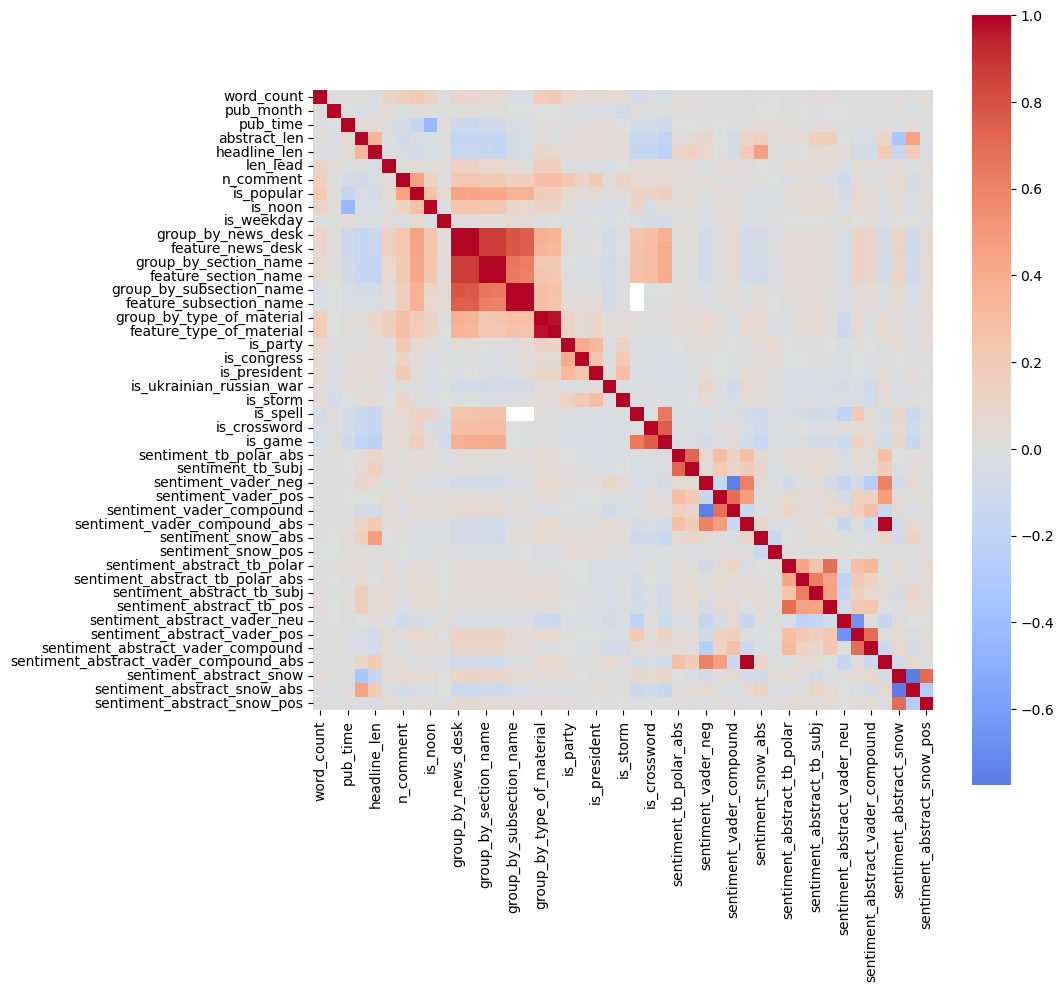

In [160]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True, center=0)

In [161]:

train = train.drop(columns=['n_comment', 'group_by_news_desk', 'group_by_section_name', 'group_by_subsection_name',
                            'group_by_type_of_material', 'feature_news_desk', 'feature_subsection_name',
                           'sentiment_abstract_snow', 'sentiment_abstract_vader_compound', 'sentiment_vader_compound', 
                           'sentiment_abstract_vader_neu', 'is_game',  'sentiment_abstract_tb_pos'])
train.columns
'''
file = pd.read_pickle('C:/Users/88690/Desktop/人工/NYCU-Intro-AI-Project/final-project/feature/feat_v1.pkl')    
for col in train.columns:
    if col not in file.columns:
        train.drop(columns=col)  
'''

"\nfile = pd.read_pickle('C:/Users/88690/Desktop/人工/NYCU-Intro-AI-Project/final-project/feature/feat_v1.pkl')    \nfor col in train.columns:\n    if col not in file.columns:\n        train.drop(columns=col)  \n"

<AxesSubplot:>

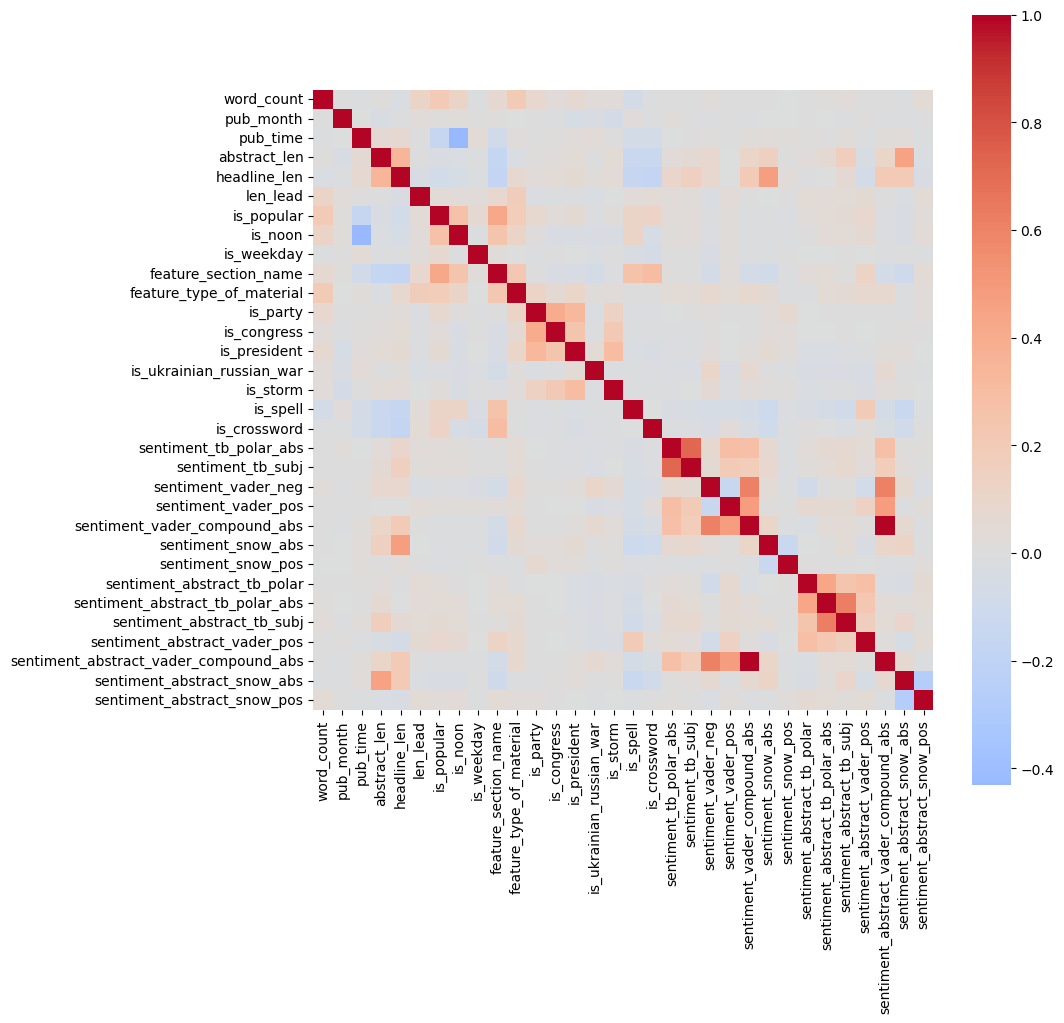

In [162]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True, center=0)

<AxesSubplot:>

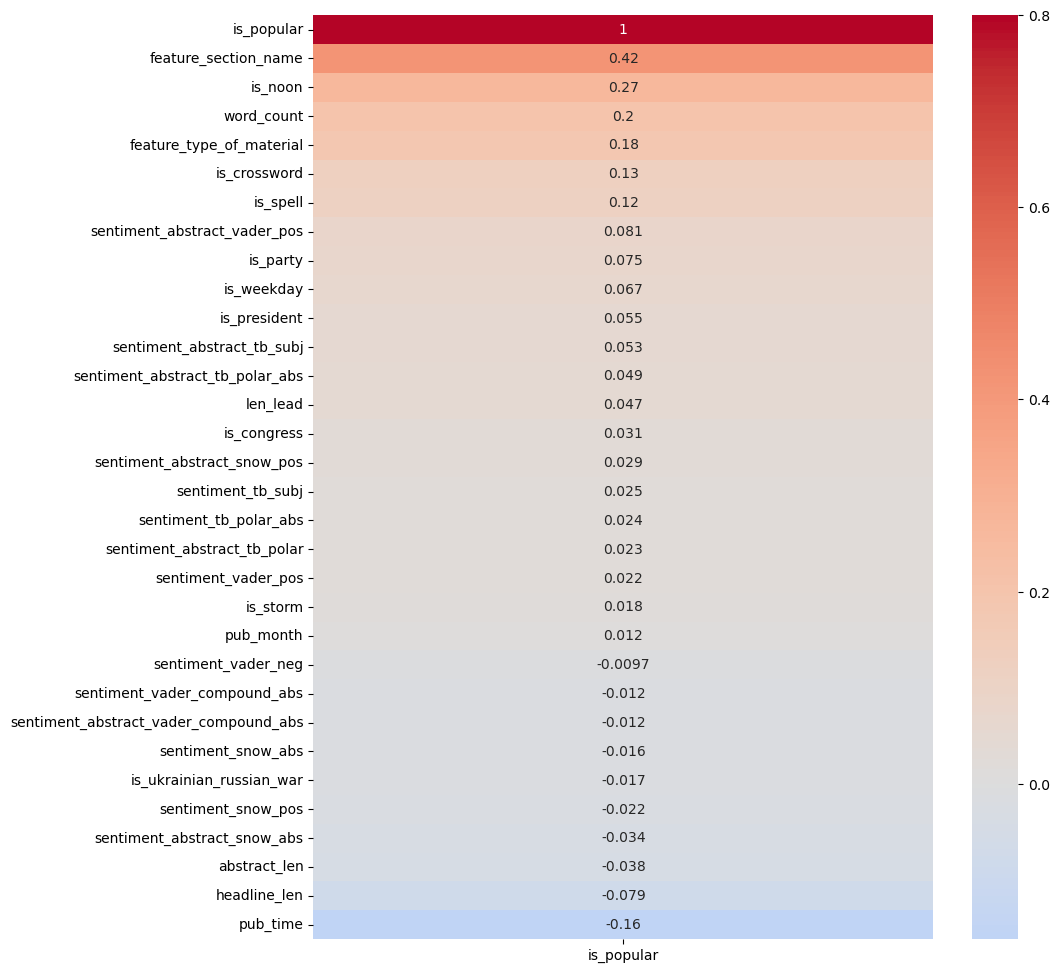

In [163]:
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['is_popular']].sort_values(ascending=False, by='is_popular'), 
            cmap='coolwarm', annot=True, vmax=0.8, center=0)

# Check the features

In [164]:
if save:
    train.to_pickle(f'./feature/{feat_data}.pkl')
feat = pd.read_pickle(f'./feature/{feat_data}.pkl')
feat

,word_count,pub_month,pub_time,abstract_len,headline_len,len_lead,is_popular,is_noon,is_weekday,feature_section_name,...,sentiment_vader_compound_abs,sentiment_snow_abs,sentiment_snow_pos,sentiment_abstract_tb_polar,sentiment_abstract_tb_polar_abs,sentiment_abstract_tb_subj,sentiment_abstract_vader_pos,sentiment_abstract_vader_compound_abs,sentiment_abstract_snow_abs,sentiment_abstract_snow_pos
0,882,1,0,8,5,54,1,0,1,0.5,...,0.2960,0.767729,0,0.000000,0.000000,0.000000,0.320,0.2960,0.156251,0
1,263,1,0,51,9,51,0,0,1,0.2,...,0.6705,0.971221,0,0.418182,0.418182,0.527273,0.137,0.6705,0.856889,0
2,695,1,1,29,10,14,0,0,1,0.2,...,0.3612,0.397023,0,0.000000,0.000000,0.000000,0.000,0.3612,0.760653,0
3,438,1,1,39,6,39,0,0,1,0.2,...,0.0516,0.986181,0,-0.107576,0.107576,0.613636,0.114,0.0516,0.961277,0
4,190,1,3,17,8,53,0,0,1,0.2,...,0.0000,0.770719,0,0.136364,0.136364,0.454545,0.201,0.0000,0.964465,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63223,1169,12,19,16,9,22,0,0,0,0.5,...,0.0000,0.351888,0,0.000000,0.000000,0.000000,0.112,0.0000,0.207019,0
63224,530,12,19,24,8,27,0,0,0,0.2,...,0.0000,0.256697,0,-0.122222,0.122222,0.188889,0.000,0.0000,0.757621,0
63225,1163,12,20,26,10,13,0,0,0,0.3,...,0.7351,0.553220,0,-0.100000,0.100000,0.783333,0.091,0.7351,0.779117,0
63226,653,12,20,15,9,29,0,0,0,0.2,...,0.0000,0.588601,0,0.000000,0.000000,0.000000,0.000,0.0000,0.621863,0


Index([ 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'len_lead', 
       'is_popular'],
      dtype='object')